In [1]:
'''
What I need to do...
1. Collect all paths that end near to one of the destination points (load destinations from xml)
2. Get a way to use x% (x steps?) of the data, also to create a tf data set of it (one hot encoded output vector) and to do mass graph predictions
3. Get the metrics results for both graph (trained on all data) and some LSTM classification implementation
'''


'\nWhat I need to do...\n1. Collect all paths that end near to one of the destination points (load destinations from xml)\n2. Get a way to use x% (x steps?) of the data, also to create a tf data set of it (one hot encoded output vector) and to do mass graph predictions\n3. Get the metrics results for both graph (trained on all data) and some LSTM classification implementation\n'

In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
from helpers.highlevel_sceneloader import HighLevelSceneLoader
from predictors.dataset_creator import TFDataSet
import tensorflow as tf
from predictors.dl_trainer import DLTrainer 
from predictors.extended_predictor import extended_predictor 
import matplotlib.pyplot as plt
import pickle
from helpers.graph import Graph
import numpy as np
import math
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
import collections
import csv
from datetime import datetime

from keras.layers import Dense, LSTM, Reshape, InputLayer, Flatten, Concatenate, Dropout, Concatenate, Input


# Collect the paths that end x meters from a destination

In [3]:
''' set some parameters '''
# Model parameters
LSTM_LAYER_SIZE = 64
DENSE_LAYER_SIZE = 128
NUM_LSTM_LAYERS = 2
NUM_DENSE_LAYERS = 2
VARIABLE_INPUT_LENGTH = False

# Dataset
SEQ_IN_LEN = 3
SEQ_OUT_LEN = 5
NOISE_STD = .3
N_REPEATS = 1

BATCH_SIZE = 5
LENGTH_STRIDE = 2


# Training parameters
MAX_EPOCHS = 100
PATIENCE = 4

# For graph
GRAPH_DIST_THRESH = 4

''' get the data '''
ROOT = os.getcwd()

rel_p_img_b = 'helpers/analysed_vars_storage/img_bounds.xml'
rel_p_dests = 'helpers/analysed_vars_storage/destination_locations.xml'
p_img_bounds = os.path.join(ROOT, rel_p_img_b)
p_dest_locs = os.path.join(ROOT, rel_p_dests)

#TODO: older version of OpenTraj needed: "git checkout d249ba6951dd0f54b532fbe2ca6edc46b0d7093f"
opentraj_root = os.path.join(ROOT, 'OpenTraj')
root_datasets = os.path.join(ROOT, 'data/path_data')
sys.path.append(opentraj_root) # add package to pythonpath

scene_data = HighLevelSceneLoader(p_img_bounds, p_dest_locs)
scene_data.load_ind(root_datasets, 7, 17)

x_min
4.
y_min
-75.
x_max
110.
y_max
-2.
x_min
4.
y_min
-75.
x_max
110.
y_max
-2.
Index 8 and length 3147
Index 9 and length 3982
Index 10 and length 4808
Index 11 and length 6069
Index 12 and length 8230
Index 13 and length 10002
Index 14 and length 12038
Index 15 and length 13448
Index 16 and length 16217
Index 17 and length 18106


In [4]:
# get list of path ids that end near to destination
def find_paths_near_destination(paths_df, destinations_mat, max_distance, id_col_name="agent_id"):
    id_list = []
    label_list = []
    for i in paths_df[id_col_name].unique():
        path_dest = np.squeeze(paths_df.loc[paths_df[id_col_name] == i].tail(1)[["pos_x", "pos_y"]].to_numpy())
        min_dist = 999.
        min_dest_id = -1
        for graph_dest, dest_id in zip(destinations_mat, range(len(destinations_mat))):
            dist = math.sqrt((path_dest[0]-graph_dest[0])**2+(path_dest[1]-graph_dest[1])**2)

            if dist < min_dist:
                min_dist = dist
                min_dest_id = dest_id
        if min_dist < max_distance:
            label_list.append([i, min_dest_id])  
        else:
            label_list.append([i, -1])  
    return np.array(label_list)




In [5]:
# Get data frame where x% of each wanted path is included
def return_x_percent_of_paths(paths_df, percentage, path_ids = None, id_col_name="agent_id"):
    paths_df_c = paths_df.copy()
    if path_ids is not None:
        paths_df_c = paths_df_c[paths_df_c[id_col_name].isin(path_ids)]
    
    shortened_df = pd.DataFrame(columns=paths_df_c.columns)
    for i in paths_df[id_col_name].unique():
        path_df = paths_df_c.loc[paths_df_c[id_col_name] == i]
        length = len(path_df)
        path_df = path_df[:math.ceil(length*percentage)]
        shortened_df = shortened_df.append(path_df)

    return shortened_df

# Get metrics results

## Metrics calculators

In [24]:
''' Average destination prob of label and n next most likely '''
def avg_top_probs(label_matrix, ordered_destinations, ordered_destination_probs):
    sum_matrix = None
    for label_row in label_matrix:
        # get path_id and label
        path_id = label_row[0]
        label = label_row[1]

        # get the according vectors
        ordered_pred_dests = np.squeeze(ordered_destinations[path_id])
        old_prob_vector = np.squeeze(ordered_destination_probs[path_id])

        # Initiate the sum matrix
        if sum_matrix is None:
            sum_matrix = np.zeros_like(old_prob_vector)

        # Get the id of label (basically on which position it was guessed)
        index = np.where(ordered_pred_dests==label)[0][0]
        
        new_prob_vector = np.hstack([old_prob_vector[index], np.delete(old_prob_vector, index)])
        new_prob_vector[new_prob_vector==np.inf] = 0
        print(new_prob_vector)
        sum_matrix = sum_matrix + new_prob_vector
    
    return sum_matrix/len(label_matrix)

In [7]:
''' Percentage of predictions that has label in top n predictions '''
def in_top_n_kpi(label_matrix, top_n_pred_dict, n):
    assert len(label_matrix) == len(top_n_pred_dict)
    total_predictions = len(label_matrix)
    correct_predictions = 0
    for label_row in label_matrix:
        path_id = label_row[0]
        label = label_row[1]

        # print("%d in list %s: %s" % (label, top_n_pred_dict[path_id],label in top_n_pred_dict[path_id]))

        if label in np.squeeze(top_n_pred_dict[path_id])[:n]:
            correct_predictions += 1

    return correct_predictions/total_predictions*100

## Data set and labels preparation

In [8]:
# Generate labels for the paths and discard paths that do not end near to a destination
label_matrix = find_paths_near_destination(scene_data.traj_dataframe, scene_data.destination_matrix, 4, "agent_id")
label_matrix = label_matrix[label_matrix[:,1]!=-1]

# Extract paths that have a label, shorten them to test effect of only having x% of the path on destination prediction
shortened_df = return_x_percent_of_paths(scene_data.traj_dataframe, .6, path_ids = label_matrix[:,0])

## LSTM Approach
Using an lstm for classifying the paths as one of the destination clusters.
We need probabilities at output for doing top n KPI etc.

1. Create Data Set (train-test-val-split)
2. Create Network
3. Train network
4. Do predictions to format that can be used in existing KPI functions

### Creating data sets and training model

In [9]:
''' Create the data sets '''

def create_dataset(df, labels_mat, num_dests, id_col_name = "agent_id"):

    # # split the labels mat into train val test
    # num_paths = len(labels_mat)
    # num_train = math.ceil(train_perc*num_paths)
    # num_val = math.ceil(val_perc*num_paths)
    
    # labels_mat_list = []
    # labels_mat_list = [labels_mat[:num_train, :], labels_mat[num_train:num_train+num_val,:], labels_mat[num_train+num_val:,:]]
    # print("Num train %s and num val %s and num test %s"%(len(labels_mat_list[0]), len(labels_mat_list[1]), len(labels_mat_list[2])))
    # # for each of the splits, create a data set

    # ds_out_list = []


    # For each path in the data set
    ds_list = []
    for row in labels_mat:  
        # get path id and according label
        path_id = row[0]
        label = row[1]

        # get full path and one hot label in tf format
        path = df[df[id_col_name]==path_id][["pos_x", "pos_y"]].to_numpy()
        path = tf.constant(path, dtype=tf.float32)   
        label_one_hot = tf.squeeze(tf.one_hot(
                    [label], num_dests, on_value=None, off_value=None, axis=None, dtype=tf.float32, name=None
                ))
        # add combo to data set
        ds_list.append((path, label_one_hot))

    output_signature=(
    tf.TensorSpec(shape=(None, 2), dtype=tf.float32),
    tf.TensorSpec(shape=(num_dests), dtype=tf.float32))

    dataset = tf.data.Dataset.from_generator(lambda: ds_list, output_signature=output_signature)
    dataset = dataset.shuffle(10).batch(1)
    return dataset


In [10]:
''' Create the prediction model '''
def create_classification_model(num_lstm_layers, num_dense_layers, lstm_size, dense_size, num_destinations):
    m_input = Input(shape=(None, 2), name="input")

    # Add LSTM layers
    m = LSTM(lstm_size, return_sequences=True)(m_input)
    for i in range(num_lstm_layers - 2):
        m = LSTM(lstm_size, return_sequences=True)(m)
    m = LSTM(lstm_size, return_sequences=False)(m)

    # Add dense layers
    for i in range(max(num_dense_layers - 1, 0)):
        m = Dense(dense_size)(m)
    
    m_output = Dense(num_destinations, kernel_initializer=tf.initializers.random_uniform,
    activation=tf.keras.activations.softmax)(m)
    
    model = tf.keras.Model(
        [m_input],
        [m_output]
    )

    return model



In [11]:
''' Train classification network '''
def compile_and_fit(train_ds, val_ds, model, save_path = None, max_epochs = 30, patience = 3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1, save_weights_only=True)

    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    cb = [early_stopping, checkpoint]

    history = model.fit(train_ds, epochs=max_epochs,
                        validation_data=val_ds,
                        callbacks=cb)    

    return history

save_path="data/model_weights/checkpoints/classifier/cp1.ckpt"

### Getting ordered top n predictions

In [12]:
# Get ordered dictionaries with path id as key and ordered predictions as value for neural network

def get_ordered_predictions_nn(model, test_ds):
    label_list = []
    dest_pred_dict = dict()
    dest_pred_probs_dict = dict()

    index = 0 # let's keep some example index for keeping track of label-prediction combination
    for inp, lbl in iter(test_ds):
        # add label to the matrix after converting one hot vector back
        lbl = np.squeeze(lbl)
        label_list.append([index, np.where(lbl>0)[0][0]])

        # do a prediction
        prediction = model(inp)

        # order the prediction result
        ordered_ids = np.array(tf.argsort(prediction, direction="DESCENDING"))
        ordered_probs = np.array(tf.sort(prediction, direction="DESCENDING"))

        # add to the dict
        dest_pred_dict[index] = ordered_ids
        dest_pred_probs_dict[index] = ordered_probs

        index += 1         

    return dest_pred_dict, dest_pred_probs_dict, np.array(label_list)

## Graph approach

### Creating the graphs

In [13]:
def __return_waypoints_ind():
    d = np.array([
    [ 65, -36],
    [ 56, -21],
    [ 66, -46],
    [ 58, -48],
    [ 67, -29],
    [ 61, -16],
    [ 45, -32],
    [ 71, -43],
    # [ 80, -52],
    # [ 68, -58],
    [ 65, -54],
    [ 48, -20],
    [ 64, -21],
    [ 46, -14]])
    return d

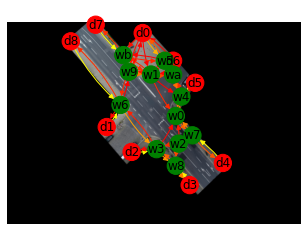

In [14]:
''' create the graph instances '''    
interest_points = __return_waypoints_ind()
g = Graph.from_matrices(interest_points, scene_data.destination_matrix, GRAPH_DIST_THRESH, .05)

df_signals = scene_data.df_to_lst_realxy_mats()
g.analyse_multiple_full_signals(df_signals, add_to_trams_mat=True)
g.recalculate_trans_mat_dependencies()
my_graph = g.create_graph(.05)
g.visualize_graph(my_graph, "thegraph.png", scene_loader=scene_data)

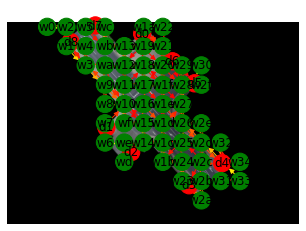

In [15]:
''' create the graph instance '''    
bound_dict = scene_data.img_bound_dict[('ind', str(11))]
bounds = [bound_dict['x_min'], bound_dict['x_max'], bound_dict['y_min'], bound_dict['y_max']]
g_grid = Graph.from_grid(scene_data.destination_matrix, bounds, 7, GRAPH_DIST_THRESH, .05, keep_orig_dest_loc=True)

df_signals = scene_data.df_to_lst_realxy_mats()
g_grid.analyse_multiple_full_signals(df_signals, add_to_trams_mat=True)

used_wps, used_dests = g_grid.get_used_nodes()

# Now create new graph with only the used nodes
g_grid = Graph.from_matrices(used_wps, used_dests, GRAPH_DIST_THRESH, 0.05) 
g_grid.analyse_multiple_full_signals(df_signals, add_to_trams_mat=True)
g_grid.recalculate_trans_mat_dependencies()

# Some visiualization
my_graph = g_grid.create_graph(.05)
g_grid.visualize_graph(my_graph, "thegraph_grid3.png", scene_loader=scene_data)

### Calculating the destinations predicted by the graph

In [16]:
def get_top_n_graph_predictions(paths_df, g, n_dests_returned, id_col_name = "agent_id"):
    ''' Get for a paths df the n top predictions for each  path doe by the graph'''
    dest_pred_dict = dict()
    dest_pred_probs_dict = dict()
    for i in paths_df[id_col_name].unique():
        path = np.squeeze(paths_df.loc[paths_df[id_col_name] == i][["pos_x", "pos_y"]].to_numpy())
        # Do prediction for each shortened path
        nodes, _ = g.analyse_full_signal(path, False, allow_out_of_threshold = True)
        top_dests, top_dests_prob = g.return_n_most_likely_points(n_dests_returned, nodes, return_type="indices")
        # Get the 3 most probable destinations and return them as list in a dict with path id
        dest_pred_dict[i]=top_dests
        dest_pred_probs_dict[i]=top_dests_prob
    return dest_pred_dict, dest_pred_probs_dict


## Calculate overall results

## Neural Network

In [17]:
# Create data sets
train_perc = .7
test_perc = .2
val_perc = .1

num_paths = len(label_matrix)
num_train = math.ceil(num_paths*train_perc)
num_test = math.ceil(num_paths*test_perc)

lbl_mat_train = label_matrix[:num_train]
lbl_mat_test = label_matrix[num_train:num_train+num_test]
lbl_mat_val = label_matrix[num_train+num_test:]

ds_train = create_dataset(shortened_df, lbl_mat_train, len(scene_data.destination_matrix))
ds_test = create_dataset(shortened_df, lbl_mat_test, len(scene_data.destination_matrix))
ds_val = create_dataset(shortened_df, lbl_mat_val, len(scene_data.destination_matrix))


In [18]:
# Create Model and train
mod = create_classification_model(2, 2, 64, 128, 9)
hist = compile_and_fit(ds_train, ds_val, mod, save_path= save_path)

Epoch 1/30
271/271 [==============================] - 7s 15ms/step - loss: 1.8212 - accuracy: 0.3358 - val_loss: 1.2353 - val_accuracy: 0.6842

Epoch 00001: val_loss improved from inf to 1.23530, saving model to data/model_weights/checkpoints/classifier/cp1.ckpt
Epoch 2/30
271/271 [==============================] - 3s 12ms/step - loss: 1.1443 - accuracy: 0.6236 - val_loss: 1.1021 - val_accuracy: 0.6842

Epoch 00002: val_loss improved from 1.23530 to 1.10213, saving model to data/model_weights/checkpoints/classifier/cp1.ckpt
Epoch 3/30
271/271 [==============================] - 4s 14ms/step - loss: 0.9629 - accuracy: 0.6605 - val_loss: 1.1802 - val_accuracy: 0.6579

Epoch 00003: val_loss did not improve from 1.10213
Epoch 4/30
271/271 [==============================] - 3s 12ms/step - loss: 0.8750 - accuracy: 0.6974 - val_loss: 1.0621 - val_accuracy: 0.6842

Epoch 00004: val_loss improved from 1.10213 to 1.06206, saving model to data/model_weights/checkpoints/classifier/cp1.ckpt
Epoch 5/

In [19]:
# Get ordered predictions
dest_pred_dict_nn, dest_pred_probs_dict_nn, label_matrix_nn = get_ordered_predictions_nn(mod, ds_test)

In [20]:
# Calculate KPI measures
a = avg_top_probs(label_matrix_nn, dest_pred_dict_nn, dest_pred_probs_dict_nn)
b = in_top_n_kpi(label_matrix_nn, dest_pred_dict_nn, 1)

### Graph

In [21]:
''' IN TOP N FOR GRAPH '''
# Get the top n destinations
graph_top_dists, _ = get_top_n_graph_predictions(shortened_df, g, 2)
graph_top_dists_grid, _ = get_top_n_graph_predictions(shortened_df, g_grid, 2)

# Get the percentage of correct guesses
top_n = in_top_n_kpi(label_matrix, graph_top_dists, 3)
top_n_grid = in_top_n_kpi(label_matrix, graph_top_dists_grid, 3)

print("Using calculated WPs: %s, using grid: %s"%(top_n, top_n_grid))

Using calculated WPs: 63.30749354005169, using grid: 70.28423772609818


In [22]:
''' AVG PREDICTION ACC OF LABEL AND ORDERED TOP DESTS '''
# Get the top n destinations
graph_top_dists, graph_top_dists_probs = get_top_n_graph_predictions(shortened_df, g, 9)

avg_top_probs(label_matrix, graph_top_dists, graph_top_dists_probs)

array([1.45055443, 3.20616837, 1.54844031, 0.5724001 , 0.37700012,
       0.3015535 , 0.27514385, 0.23433469, 0.09973524])

# Loop for getting comparison results

In [25]:
# Generate labels for the paths and discard paths that do not end near to a destination
label_matrix = find_paths_near_destination(scene_data.traj_dataframe, scene_data.destination_matrix, 4, "agent_id")
label_matrix_no_bad = label_matrix[label_matrix[:,1]!=-1]

full_df = scene_data.traj_dataframe
num_paths_full_df = len(label_matrix)
num_labeled_paths_full_df = len(label_matrix_no_bad)


# train the networks on the available data

num_paths_avail = [.2, .3, .4, .5, .6, .7, .8, .9, 1.]
percentage_of_path_avail = [.1, .2, .3, .4, .5, .7, .8, .9, 1.]


# set up the csv writer
csv_headers = ["NumPathsAvail", "PercOfPathAvail", "PredMethod", "InTop1", "InTop2", "InTop3", "PercLbl", "Perc1", "Perc2", "Perc3", "Perc4", "Perc5", "Perc6", "Perc7", "Perc8"]
csv_folder_path = "data/results/destination_pred"
filename = 'results_' + datetime.now().strftime("%d_%m_%Y__%H_%M") + ".csv"
full_path = os.path.join(csv_folder_path, filename)

with open(full_path, 'w', newline='\n') as csvfile:
    my_writer = csv.writer(csvfile, delimiter=',')
    my_writer.writerow(csv_headers)

for paths_avail in num_paths_avail:

    shorter_label_matrix = label_matrix_no_bad[:math.ceil(paths_avail*num_paths_full_df)]
    shorter_df = return_x_percent_of_paths(full_df, 1., shorter_label_matrix[:,0]) # extract the path ids
    print("Label matrix l %s and df l %s"%(len(shorter_label_matrix), len(shorter_df)))
    ''' TRAIN THE GRAPHS '''
    # WP graph
    interest_points = __return_waypoints_ind()
    g = Graph.from_matrices(interest_points, scene_data.destination_matrix, GRAPH_DIST_THRESH, .05)

    df_signals = scene_data.df_to_lst_realxy_mats_ext(shorter_df)
    g.analyse_multiple_full_signals(df_signals, add_to_trams_mat=True)
    g.recalculate_trans_mat_dependencies()

    # GRID GRAPH
    bound_dict = scene_data.img_bound_dict[('ind', str(11))]
    bounds = [bound_dict['x_min'], bound_dict['x_max'], bound_dict['y_min'], bound_dict['y_max']]
    g_grid = Graph.from_grid(scene_data.destination_matrix, bounds, 7, GRAPH_DIST_THRESH, .05, keep_orig_dest_loc=True)

    df_signals = scene_data.df_to_lst_realxy_mats_ext(shorter_df)
    g_grid.analyse_multiple_full_signals(df_signals, add_to_trams_mat=True)

    used_wps, used_dests = g_grid.get_used_nodes()

    # Now create new graph with only the used nodes
    g_grid = Graph.from_matrices(used_wps, used_dests, GRAPH_DIST_THRESH, 0.05) 
    g_grid.analyse_multiple_full_signals(df_signals, add_to_trams_mat=True)
    g_grid.recalculate_trans_mat_dependencies()

    ''' TRAIN THE MODEL '''
    # Create data sets
    train_perc = .7
    test_perc = .2
    val_perc = .1

    num_paths = len(shorter_label_matrix)
    num_train = math.ceil(num_paths*train_perc)
    num_test = math.ceil(num_paths*test_perc)

    lbl_mat_train = shorter_label_matrix[:num_train]
    lbl_mat_test = shorter_label_matrix[num_train:num_train+num_test]
    lbl_mat_val = shorter_label_matrix[num_train+num_test:]

    ds_train = create_dataset(shorter_df, lbl_mat_train, len(scene_data.destination_matrix))    
    ds_val = create_dataset(shorter_df, lbl_mat_val, len(scene_data.destination_matrix))

    mod = create_classification_model(2, 2, 64, 128, 9)
    _ = compile_and_fit(ds_train, ds_val, mod, save_path= save_path)

    ''' EVALUATING METHODS FOR %s AVAILABLE OF EACH PATH '''
    
    for path_percentage in percentage_of_path_avail:        
        even_shorter_df = return_x_percent_of_paths(shorter_df, path_percentage, shorter_label_matrix[:,0])
        # NEURAL NETWORK
        ds_test = create_dataset(even_shorter_df, lbl_mat_test, len(scene_data.destination_matrix))
        # Get ordered predictions
        dest_pred_dict_nn, dest_pred_probs_dict_nn, label_matrix_nn = get_ordered_predictions_nn(mod, ds_test)
        # Get KPIs
        nn_top_probs = avg_top_probs(label_matrix_nn, dest_pred_dict_nn, dest_pred_probs_dict_nn)
        top_n_nn_1 = in_top_n_kpi(label_matrix_nn, dest_pred_dict_nn, 1)
        top_n_nn_2 = in_top_n_kpi(label_matrix_nn, dest_pred_dict_nn, 2)
        top_n_nn_3 = in_top_n_kpi(label_matrix_nn, dest_pred_dict_nn, 3)

        # GRAPHS
        # Get the top n destinations
        graph_top_dists, graph_top_probs = get_top_n_graph_predictions(even_shorter_df, g, 9)
        graph_top_dists_grid, graph_top_probs_grid = get_top_n_graph_predictions(even_shorter_df, g_grid, 9)

        # Get KPIs
        top_n_g_1 = in_top_n_kpi(shorter_label_matrix, graph_top_dists, 1)
        top_n_g_2 = in_top_n_kpi(shorter_label_matrix, graph_top_dists, 2)
        top_n_g_3 = in_top_n_kpi(shorter_label_matrix, graph_top_dists, 3)

        top_n_g_grid_1 = in_top_n_kpi(shorter_label_matrix, graph_top_dists_grid, 1)
        top_n_g_grid_2 = in_top_n_kpi(shorter_label_matrix, graph_top_dists_grid, 2)
        top_n_g_grid_3 = in_top_n_kpi(shorter_label_matrix, graph_top_dists_grid, 3)

        top_probs_g = avg_top_probs(shorter_label_matrix, graph_top_dists, graph_top_probs)
        top_probs_g_grid = avg_top_probs(shorter_label_matrix, graph_top_dists_grid, graph_top_probs_grid)
        
        # Write them away for later analysis
        line_g_grid = [paths_avail, path_percentage, "g_grid", top_n_g_grid_1, top_n_g_grid_2, top_n_g_grid_3]
        line_g_grid.extend(top_probs_g_grid)
        line_g = [paths_avail, path_percentage, "g", top_n_g_1, top_n_g_2, top_n_g_3]
        line_g.extend(top_probs_g)
        line_nn = [paths_avail, path_percentage, "nn", top_n_nn_1, top_n_nn_2, top_n_nn_3]
        line_nn.extend(nn_top_probs)

        with open(full_path, 'a', newline='\n') as csvfile:
            my_writer = csv.writer(csvfile, delimiter=',')
            my_writer.writerow(line_g_grid)
            my_writer.writerow(line_g)
            my_writer.writerow(line_nn)      


Label matrix l 159 and df l 3931
Epoch 1/30
112/112 [==============================] - 7s 30ms/step - loss: 1.4428 - accuracy: 0.5268 - val_loss: 1.6774 - val_accuracy: 0.6000

Epoch 00001: val_loss improved from inf to 1.67743, saving model to data/model_weights/checkpoints/classifier/cp1.ckpt
Epoch 2/30
112/112 [==============================] - 3s 27ms/step - loss: 0.7001 - accuracy: 0.7857 - val_loss: 1.3770 - val_accuracy: 0.6000

Epoch 00002: val_loss improved from 1.67743 to 1.37702, saving model to data/model_weights/checkpoints/classifier/cp1.ckpt
Epoch 3/30
112/112 [==============================] - 3s 24ms/step - loss: 0.5673 - accuracy: 0.8036 - val_loss: 1.5206 - val_accuracy: 0.6000

Epoch 00003: val_loss did not improve from 1.37702
Epoch 4/30
112/112 [==============================] - 3s 27ms/step - loss: 0.4450 - accuracy: 0.8304 - val_loss: 1.2765 - val_accuracy: 0.6000

Epoch 00004: val_loss improved from 1.37702 to 1.27647, saving model to data/model_weights/checkpo

KeyboardInterrupt: 